# Does rain interfere with SWOT data collection?

## Setup

* Map of MRMS over nodes (ideally intensity)
* Change MRMS to intensity
* Toby will email JJ
* Change heat map to index so they are in order
* Expand study area

In [1]:
import gzip
import os
import pathlib
import tempfile
from concurrent.futures import ThreadPoolExecutor, as_completed
from io import StringIO, BytesIO

import earthaccess
import geopandas as gpd
import holoviews as hv
import hvplot.pandas
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shapely
import requests
import rioxarray as rxr
import xarray as xr
from tqdm.notebook import tqdm

from download import fetch_hydrocron, download_mrms
from plot import plot_heatmap
from utilities import filter_bits

# Preferences
use_cache = True

# Set up data path
data_dir = pathlib.Path().cwd().parent / 'data'
data_dir.mkdir(exist_ok=True, parents=True)
precip_path = data_dir / 'MRMS_{var_name}.csv'
swot_path = data_dir / 'swot_timeseries.csv'

# Satellite tracks for test site on Willamette River
passes = [39, 274, 345]
# Site bounding box
bounds = (-123.4, 44, -123, 45)
bbox = shapely.geometry.box(*bounds)
start_time = '2023-01-01T00:00:00Z'
end_time = '2025-01-01T00:00:00Z'

# Set up data path
data_dir = pathlib.Path().cwd().parent / 'data'
data_dir.mkdir(exist_ok=True, parents=True)
precip_path = data_dir / 'MRMS_{var_name}.csv'
swot_path = data_dir / 'swot_timeseries.csv'

## Define the study area

### Get node IDs from earthaccess

In [2]:
earthaccess.login()

In [3]:
# Search for the SWOT dataset
swot_datasets = earthaccess.search_datasets(keyword="SWOT")
for dataset in swot_datasets:
    try:
        print(dataset['umm']['CollectionCitations'][0]['Title'], 
              dataset['umm']['ShortName'])
    except:
        print('Dataset missing title information')

SWOT Level 2 Water Mask Raster Image Data Product, Version C SWOT_L2_HR_Raster_2.0
SWOT Level 2 Water Mask Pixel Cloud Data Product, Version C SWOT_L2_HR_PIXC_2.0
SWOT Level 2 River Single-Pass Vector Data Product, Version C SWOT_L2_HR_RiverSP_2.0
SWOT Level 2 KaRIn Low Rate Sea Surface Height Data Product, Version C SWOT_L2_LR_SSH_2.0
SWOT Level 2 Lake Single-Pass Vector Data Product, Version C SWOT_L2_HR_LakeSP_2.0
SWOT Level 2 River Single-Pass Vector Data Product, Version D SWOT_L2_HR_RiverSP_D
SWOT Level 2 KaRIn Low Rate Sea Surface Height Data Product, Version D SWOT_L2_LR_SSH_D
SWOT Level 2 Nadir Altimeter Geophysical Data Record with Waveforms Version 1.0 SWOT_L2_NALT_GDR_2.0
SWOT Level 2 Nadir Altimeter Interim Geophysical Data Record with Waveforms Version 1.0 SWOT_L2_NALT_IGDR_2.0
SWOT Level 2 Nadir Altimeter Operational Geophysical Data Record with Waveforms Version 1.0 SWOT_L2_NALT_OGDR_2.0
SWOT Level 4 River Discharge Products Version 1 SWOT_L4_DAWG_SOS_DISCHARGE
Dataset 

In [4]:
# Get the metadata for SWOT river products in the Willamette bounding box
vector_meta = earthaccess.search_data(
    short_name="SWOT_L2_HR_RiverSP_node_2.0",
    bounding_box=bounds,
    # Only need one pass for metadata
    temporal=('2024-01-01', '2024-02-01')
)
willamette_meta = [
    meta for meta in vector_meta 
    if (meta['umm']['SpatialExtent']['HorizontalSpatialDomain']
        ['Track']['Passes'][0]['Pass'])
    in passes]
willamette_meta[0]

Collection: {'Version': '2.0', 'ShortName': 'SWOT_L2_HR_RiverSP_node_2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': -77.089598228, 'Longitude': 144.734847029}, {'Latitude': -78.236115915, 'Longitude': 144.734847029}, {'Latitude': -76.876353092, 'Longitude': 171.05628019}, {'Latitude': -75.179170739, 'Longitude': 180}, {'Latitude': -74.24644568549999, 'Longitude': 180}, {'Latitude': -75.841080029, 'Longitude': 168.965405592}, {'Latitude': -77.089598228, 'Longitude': 144.734847029}]}}, {'Boundary': {'Points': [{'Latitude': -75.179170739, 'Longitude': -180}, {'Latitude': -73.481988386, 'Longitude': -170.658783296}, {'Latitude': -69.017288841, 'Longitude': -159.331850352}, {'Latitude': -64.027313382, 'Longitude': -152.143021382}, {'Latitude': -58.761539499, 'Longitude': -147.304927805}, {'Latitude': -53.337452313, 'Longitude': -143.859699409}, {'Latitude': -47.815098058, 'Longitude': -141.285440354}, {'Latitude': -42.227832282, 'Longitude': -139.282026991}, {'Latitude': -36.5956463, 'Longitude': -137.66662162}, {'Latitude': -30.93139442, 'Longitude': -136.321631479}, {'Latitude': -25.243922948, 'Longitude': -135.167486372}, {'Latitude': -19.539745533, 'Longitude': -134.147608635}, {'Latitude': -13.823991705, 'Longitude': -133.219650079}, {'Latitude': -8.100972727, 'Longitude': -132.350080686}, {'Latitude': -2.374539997, 'Longitude': -131.510613172}, {'Latitude': 0.488816703, 'Longitude': -131.094114533}, {'Latitude': 6.213560933, 'Longitude': -130.25200188}, {'Latitude': 11.932599736, 'Longitude': -129.376353412}, {'Latitude': 17.641983548, 'Longitude': -128.439145293}, {'Latitude': 23.337243263, 'Longitude': -127.40739359099999}, {'Latitude': 29.013029157, 'Longitude': -126.23981581000001}, {'Latitude': 34.662546094, 'Longitude': -124.881889857}, {'Latitude': 40.276622422, 'Longitude': -123.25803893700001}, {'Latitude': 45.842100123, 'Longitude': -121.258582642}, {'Latitude': 51.338911739, 'Longitude': -118.716854748}, {'Latitude': 56.734470077, 'Longitude': -115.367188696}, {'Latitude': 61.972216352, 'Longitude': -110.764784346}, {'Latitude': 66.946763054, 'Longitude': -104.131720355}, {'Latitude': 71.447935666, 'Longitude': -94.09305914999999}, {'Latitude': 75.044865485, 'Longitude': -78.51292197599997}, {'Latitude': 76.968276197, 'Longitude': -56.035714036}, {'Latitude': 78.102910198, 'Longitude': -56.79944912000002}, {'Latitude': 76.019975969, 'Longitude': -80.92869226099998}, {'Latitude': 72.220320073, 'Longitude': -96.81242612699998}, {'Latitude': 67.558606653, 'Longitude': -106.640871411}, {'Latitude': 62.468077627, 'Longitude': -112.984428729}, {'Latitude': 57.14621816, 'Longitude': -117.330604096}, {'Latitude': 51.688178369, 'Longitude': -120.47374244299999}, {'Latitude': 46.143853744, 'Longitude': -122.853074123}, {'Latitude': 40.541623404, 'Longitude': -124.725645085}, {'Latitude': 34.898867444, 'Longitude': -126.25068884000001}, {'Latitude': 29.226993856, 'Longitude': -127.53221924799999}, {'Latitude': 23.534015403, 'Longitude': -128.6416727}, {'Latitude': 17.825953694, 'Longitude': -129.630615028}, {'Latitude': 12.107646429, 'Longitude': -130.538275044}, {'Latitude': 6.383237199, 'Longitude': -131.396285001}, {'Latitude': 0.656492138, 'Longitude': -132.231888518}, {'Latitude': -2.206626058, 'Longitude': -132.649199339}, {'Latitude': -7.930093263, 'Longitude': -133.498468643}, {'Latitude': -13.646733081, 'Longitude': -134.389149195}, {'Latitude': -19.352469895, 'Longitude': -135.350470261}, {'Latitude': -25.042615437, 'Longitude': -136.417508062}, {'Latitude': -30.711458165, 'Longitude': -137.634911284}, {'Latitude': -36.351610213, 'Longitude': -139.062536712}, {'Latitude': -41.952914779, 'Longitude': -140.784517299}, {'Latitude': -47.500530492, 'Longitude': -142.924633224}, {'Latitude': -52.971396993, 'Longitude': -145.673651788}, {'Latitude': -58.327328868, 'Longitude': -149.340173478}, {'Latitude': -63.500646942, 'Longitude': -154.448331504}, {'

### Filter nodes

In [5]:
# Open vector dataset
files = earthaccess.open(willamette_meta)

# Get the pass number from the metadata for each file
swot_gdf_list = []
for meta, file in tqdm(zip(willamette_meta, files)):
    gdf = gpd.read_file(file)
    gdf['pass'] = str(
        (meta['umm']['SpatialExtent']['HorizontalSpatialDomain']
         ['Track']['Passes'][0]['Pass']))
    swot_gdf_list.append(gdf)
swot_gdf = pd.concat(swot_gdf_list)

# Clip the data to the bounding box
site_gdf = swot_gdf.clip(bbox)

# Convert str to int for reach_id and node_id
site_gdf.loc[:, 'reach_id'] = site_gdf['reach_id'].astype(int)
site_gdf.loc[:, 'node_id'] = site_gdf['node_id'].astype(int)

# Wrangle
site_gdf = (
    site_gdf
    # Select desired columns
    [['reach_id', 'node_id', 'pass', 'geometry']]
    # Drop duplicate locations
    .groupby('node_id').first()
    # Sort by node_id
    .sort_values('node_id')
    # Reset index in correct order
    .reset_index()
)

# Drop side channels
site_gdf = site_gdf.loc[site_gdf.reach_id < 78220000400]

site_gdf.info()

QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 870 entries, 0 to 869
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   node_id   870 non-null    int64   
 1   reach_id  870 non-null    object  
 2   pass      870 non-null    object  
 3   geometry  870 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 34.0+ KB


### Plot study area

In [6]:
# Plot nodes
site_gdf.hvplot(
    geo=True, tiles='CartoLight',
    frame_width=250, frame_height=500)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

## SWOT data time series

### Download SWOT data from hydrocron

In [7]:
fields = [
    # Index
    'node_id',
    'time_str',
    # Measurements
    'wse',
    'width',
    'area_total',
    # Quality -- to filter
    'node_q_b', # Not far or near swath (bits 13 + 14 set)
    'ice_clim_f', # Not ice (== 0)
    'xovr_cal_q', # Not bad xover (< 2)
    'p_dam_id', # Affected by dam
    # Possibly affected by rain
    'dark_frac', 'n_good_pix', # Were measurements made
    'lat', 'lon', 'lat_u', 'lon_u', # Location + uncertainties
    'rdr_sig0', 'rdr_sig0_u', 'rdr_pol', # Backscatter coefficient
    'dry_trop_c', 'wet_trop_c', 'iono_c', 'xovr_cal_c', # Corrections
    'p_wse', 'p_wse_var', 'p_width', 'p_wid_var', # Prior estimages
]

fetch_hydrocron_study = (
    lambda row: fetch_hydrocron(row, start_time, end_time, fields)
)

# Download only once
if not swot_path.exists() or not use_cache:
    # Threaded execution
    swot_ts_df_list = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        # Submit all tasks
        futures = [executor.submit(fetch_hydrocron_study, row) 
                for _, row in site_gdf.iterrows()]
        
        # Collect results with tqdm progress bar
        for future in tqdm(as_completed(futures), total=len(futures)):
            result = future.result()
            if result is not None:
                swot_ts_df_list.append(result)

    # Combine all results
    swot_ts_df = pd.concat(swot_ts_df_list)

    swot_ts_df.to_csv(swot_path)

### Filter SWOT data

In [8]:
swot_ts_df = (
    pd.read_csv(
        swot_path, 
        na_values=['no_data'],
        index_col=['node_id', 'time_str'],
        parse_dates=True)
    .rename_axis(index={"time_str": "time"})
)
# Remove NA rows
swot_ts_df = swot_ts_df[swot_ts_df.index.get_level_values("time").notna()]

# Filter data
swot_filter_df = swot_ts_df.copy()
# Not ice
swot_filter_df = swot_filter_df[swot_filter_df.ice_clim_f==0]
# Not bad xover
swot_filter_df = swot_filter_df[swot_filter_df.xovr_cal_q<2]
# Not far or near swath
swot_filter_df = swot_filter_df[swot_filter_df.node_q_b.apply(filter_bits)]

swot_filter_df

/var/folders/dn/99vk45cd5n56wsnl3hxc1bw40000gp/T/ipykernel_19786/2795151691.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(


wse       width  area_total  \
node_id        time                                                           
78220000150171 2023-04-02 08:16:14+00:00   33.75704  222.899464     44981.9   
               2023-04-03 08:06:52+00:00   34.08350  211.829094     42747.8   
               2023-04-04 07:57:29+00:00   34.31415  253.220187     51100.7   
               2023-04-05 07:48:07+00:00   34.00218  210.039933     42386.8   
               2023-04-07 07:29:23+00:00   33.98597  218.893170     44173.4   
...                                             ...         ...         ...   
78220000310411 2024-10-23 15:19:00+00:00  136.03564  194.020455     39356.7   
               2024-11-01 00:23:08+00:00  136.19781  193.196698     39189.6   
               2024-11-21 21:08:15+00:00  137.17491  463.686901     94057.9   
               2024-12-04 08:49:08+00:00  136.38287  163.946410     33256.2   
               2024-12-25 05:34:13+00:00  136.56284  275.113149     55806.1   

                                          node_q_b  ice_clim_f  xovr_cal_q  \
node_id        time                                                          
78220000150171 2023-04-02 08:16:14+00:00        14           0           0   
               2023-04-03 08:06:52+00:00         6           0           0   
               2023-04-04 07:57:29+00:00         6           0           0   
               2023-04-05 07:48:07+00:00         4           0           0   
               2023-04-07 07:29:23+00:00         6           0           0   
...                                            ...         ...         ...   
78220000310411 2024-10-23 15:19:00+00:00        10           0           0   
               2024-11-01 00:23:08+00:00         6           0           1   
               2024-11-21 21:08:15+00:00    524298           0           1   
               2024-12-04 08:49:08+00:00         6           0           1   
               2024-12-25 05:34:13+00:00        14           0           1   

                                          p_dam_id  dark_frac  n_good_pix  \
node_id        time                                                         
78220000150171 2023-04-02 08:16:14+00:00         0   0.000000         139   
               2023-04-03 08:06:52+00:00         0   0.006865         136   
               2023-04-04 07:57:29+00:00         0   0.000000         145   
               2023-04-05 07:48:07+00:00         0   0.000000         136   
               2023-04-07 07:29:23+00:00         0   0.006652         115   
...                                            ...        ...         ...   
78220000310411 2024-10-23 15:19:00+00:00         0   0.000000          44   
               2024-11-01 00:23:08+00:00         0   0.000000          29   
               2024-11-21 21:08:15+00:00         0   0.000000          86   
               2024-12-04 08:49:08+00:00         0   0.074650          32   
               2024-12-25 05:34:13+00:00         0   0.014738          38   

                                                lat  ...  rdr_sig0_units  \
node_id        time                                  ...                   
78220000150171 2023-04-02 08:16:14+00:00  44.988963  ...               1   
               2023-04-03 08:06:52+00:00  44.989193  ...               1   
               2023-04-04 07:57:29+00:00  44.988931  ...               1   
               2023-04-05 07:48:07+00:00  44.989028  ...               1   
               2023-04-07 07:29:23+00:00  44.989161  ...               1   
...                                             ...  ...             ...   
78220000310411 2024-10-23 15:19:00+00:00  44.025511  ...               1   
               2024-11-01 00:23:08+00:00  44.025914  ...               1   
               2024-11-21 21:08:15+00:00  44.022148  ...               1   
               2024-12-04 08:49:08+00:00  44.025814  ...               1   
               2024-12-25 05:34:13+00:00  44.025829  ...               1   

              

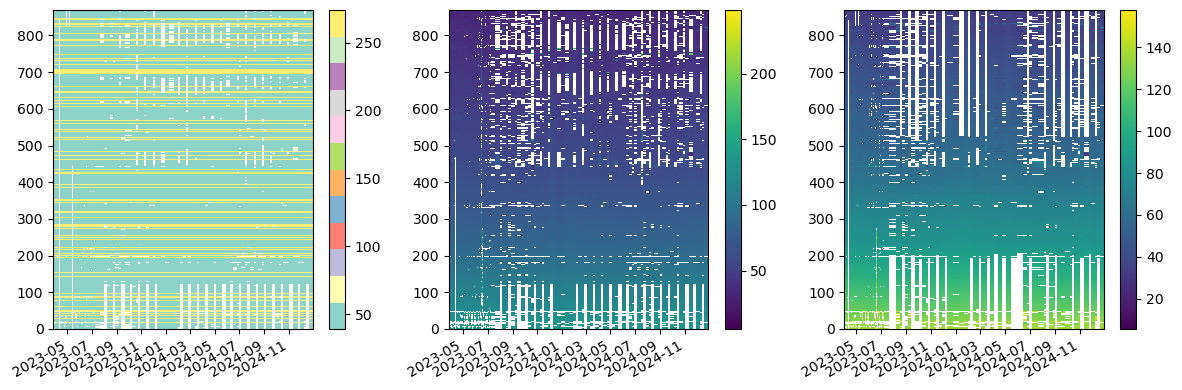

In [9]:
swot_pass_df = (
    swot_ts_df
    .reset_index()
    .merge(
        site_gdf[['node_id', 'pass']],
        on='node_id',
        how='left'
    )
    .set_index(['node_id', 'time'])
    [['pass']]
    .astype('int16')
)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
plot_heatmap(swot_pass_df, column='pass', fig=fig, ax=ax1, cmap='Set3')
plot_heatmap(swot_ts_df, column='wse', fig=fig, ax=ax2)
plot_heatmap(swot_filter_df, column='wse', fig=fig, ax=ax3)
plt.tight_layout()
plt.show()

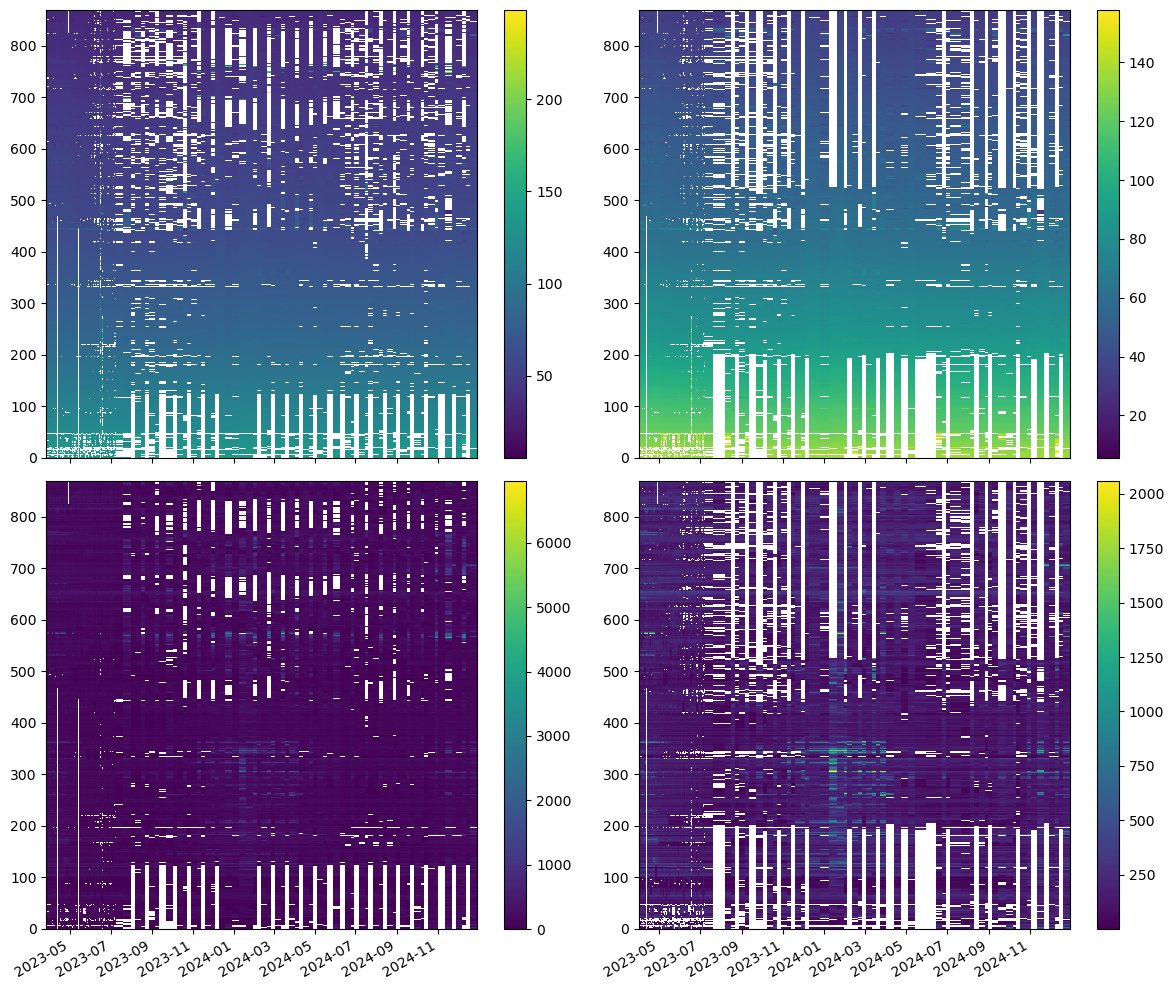

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
plot_heatmap(swot_filter_df, column='wse', fig=fig, ax=ax2)
plot_heatmap(swot_ts_df, column='wse', fig=fig, ax=ax1)
plot_heatmap(swot_filter_df, column='width', fig=fig, ax=ax4)
plot_heatmap(swot_ts_df, column='width', fig=fig, ax=ax3)
plt.tight_layout()
plt.show()

## Download MRMS data

In [12]:
# MRMS variable names
mrms_vars = dict(
    flag=('PrecipFlag_00.00', False),  # Binary flag (0/1) for precipitation
    rate=('PrecipRate_00.00', False),  # Precipitation rate (mm/hr)
    quality=('RadarAccumulationQualityIndex_01H_00.00', True)  # Quality index (0-100)
    #zdr=('MergedZdr_00.00', False)  # Differential reflectivity (dB)
)
# Download MRMS data for each variable if not already downloaded
for _, (var_name, hourly) in mrms_vars.items():
    var_path = precip_path.parent / precip_path.name.format(var_name=var_name)
    print(var_path)
    if not var_path.exists() or not use_cache:
        download_mrms(
            swot_ts_df, 
            var_name=var_name, 
            precip_path=precip_path,
            hourly=hourly)

/Users/elsa/01-research/swot-precip-validation/data/MRMS_PrecipFlag_00.00.csv
/Users/elsa/01-research/swot-precip-validation/data/MRMS_PrecipRate_00.00.csv
/Users/elsa/01-research/swot-precip-validation/data/MRMS_RadarAccumulationQualityIndex_01H_00.00.csv


  0%|          | 0/800 [00:00<?, ?it/s]

https://noaa-mrms-pds.s3.amazonaws.com/CONUS/RadarAccumulationQualityIndex_01H_00.00/20230329/MRMS_RadarAccumulationQualityIndex_01H_00.00_20230329-080000.grib2.gz


/Users/elsa/miniconda3/envs/swot/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


https://noaa-mrms-pds.s3.amazonaws.com/CONUS/RadarAccumulationQualityIndex_01H_00.00/20230329/MRMS_RadarAccumulationQualityIndex_01H_00.00_20230329-080000.grib2.gz


/Users/elsa/miniconda3/envs/swot/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


KeyboardInterrupt: 

## Merge SWOT and precipitation flag data

In [ ]:
precip_df = pd.read_csv(
    precip_path, 
    index_col=['node_id', 'time_str'],
    parse_dates=True
)
precip_df['precip'] = precip_df.precip_flag.isin([1, 6, 7, 10, 91, 96])
precip_df.precip.sum()

In [ ]:
swot_precip_flag_df = swot_ts_df.merge(
    precip_df,
    left_index=True, 
    right_index=True
)
swot_precip_df.info()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_heatmap(swot_precip_df, column='wse', ax=ax1, cmap='Blues')
plot_heatmap(swot_precip_df, column='precip_flag', ax=ax2, cmap='tab10')
plt.tight_layout()
plt.show()

In [ ]:
sns.violinplot(
    data=swot_precip_df,
    x='precip_flag', y='rdr_sig0',
    inner='quartile'
)

In [ ]:
sns.violinplot(
    data=swot_precip_df,
    x='precip_flag', y='dark_frac',
    inner='quartile'
)

In [ ]:
sns.kdeplot(
    data=swot_precip_df,
    x='dark_frac', hue='precip_flag',
    multiple='layer', common_norm=False,
    palette='tab10', alpha=0.5,
    log_scale=(False, True)
)

In [ ]:
sns.kdeplot(
    data=swot_precip_df,
    x='dark_frac', hue='precip',
    multiple='layer', common_norm=False,
    palette='tab10', alpha=0.5,
    log_scale=(False, True)
)

In [ ]:
swot_precip_df

In [ ]:
swot_vars_df = (
    swot_precip_df
    .copy()
    [[
        'wse', 'width',
        'dark_frac', 
        #'lat_u', 'lon_u',
        'rdr_sig0',
        #'dry_trop_c', 'wet_trop_c','iono_c', 'xovr_cal_c', 
        'precip'
    ]]
)
sns.pairplot(
    swot_vars_df, 
    kind='kde', hue='precip', corner=True, 
    diag_kws={'common_norm': False})

In [ ]:
swot_vars_df = (
    swot_precip_df
    .copy()
    [[
        'wse', 'width',
        #'dark_frac', 
        #'lat_u', 'lon_u',
        #'rdr_sig0',
        'dry_trop_c', 'wet_trop_c','iono_c', 'xovr_cal_c', 
        'precip'
    ]]
)
sns.pairplot(
    swot_vars_df, 
    kind='kde', hue='precip', corner=True, 
    diag_kws={'common_norm': False})

In [ ]:
# Edge detection
swot_precip_df[['wse']].groupby('node_id').lag(1)